In [2]:
from nltk.corpus import gutenberg
import pandas as pd
from nltk.corpus import stopwords
import string
import re
from keras.preprocessing.sequence import skipgrams
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:


def strip(line, stop_words):
    strippedLine = []
    for word in line:
        strippedWord = word.lower()
        if strippedWord.isdigit() or strippedWord in stop_words or strippedWord == '' or strippedWord == ' ' or strippedWord in string.punctuation or not strippedWord.isalnum():
            continue
        strippedLine.append(strippedWord)
    return strippedLine

In [4]:

austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')
print(f"Length of austen should be 16498: {len(austen)}")
stop_words = stopwords.words('english')
newAusten = []
for line in austen:
    strippedLine = strip(line,stop_words)
    if len(strippedLine) > 2:
        newAusten.append(strippedLine)
print(f"Length of New Austen should be 13927: {len(newAusten)}")
print('Processed line:', newAusten[10])


Length of austen should be 16498: 16498
Length of New Austen should be 13927: 13923
Processed line: ['therefore', 'succession', 'norland', 'estate', 'really', 'important', 'sisters', 'fortune', 'independent', 'might', 'arise', 'father', 'inheriting', 'property', 'could', 'small']


In [5]:
# create index-word relationship
word2idx = {'<PADDINGTOKEN>': 0}
idx2word ={}# {0:'<PADDINGTOKEN>'}
sents_as_ids = []
for line in newAusten:
    sentId = []
    for word in line:
        if word in word2idx:
            sentId.append(word2idx[word])
            continue
        count = len(word2idx)
        word2idx[word] = count
        idx2word[count] = word
        sentId.append(count)
    sents_as_ids.append(sentId)
    
        
vocab_size = len(word2idx)
embed_size = 100

In [7]:
print(vocab_size)
print('\nSample word2idx: ', list(word2idx.items())[:10])
print('\nSample idx2word:', list(idx2word.items())[:10])
print('\nSample normalized corpus:', newAusten[-3:])
print('\nAbove sentence as a list of ids:' , sents_as_ids[-3:])

10093

Sample word2idx:  [('<PADDINGTOKEN>', 0), ('sense', 1), ('sensibility', 2), ('jane', 3), ('austen', 4), ('family', 5), ('dashwood', 6), ('long', 7), ('settled', 8), ('sussex', 9)]

Sample idx2word: [(1, 'sense'), (2, 'sensibility'), (3, 'jane'), (4, 'austen'), (5, 'family'), (6, 'dashwood'), (7, 'long'), (8, 'settled'), (9, 'sussex'), (10, 'estate')]

Sample normalized corpus: [['anne', 'tenderness', 'full', 'worth', 'captain', 'wentworth', 'affection'], ['profession', 'could', 'ever', 'make', 'friends', 'wish', 'tenderness', 'less', 'dread', 'future', 'war', 'could', 'dim', 'sunshine'], ['gloried', 'sailor', 'wife', 'must', 'pay', 'tax', 'quick', 'alarm', 'belonging', 'profession', 'possible', 'distinguished', 'domestic', 'virtues', 'national', 'importance']]

Above sentence as a list of ids: [[3572, 2691, 1542, 597, 6196, 9017, 186], [3016, 81, 344, 233, 1055, 568, 2691, 534, 3985, 428, 6622, 81, 9603, 1927], [5139, 8960, 127, 312, 686, 5110, 1763, 1858, 683, 3016, 496, 856, 8

In [6]:
skip_grams = [skipgrams(sent, vocabulary_size=vocab_size, window_size=5) for sent in
sents_as_ids]

In [7]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]
# This shows whether the two words occur together in the context window(size of which is set above) 
# 1 if they co-occur 0 
# We get all the times that a word occurs from the first sentence co-occurs with something 
# and only a handful (negative sampling) of the words it does not co-occur with 
for i in range(len(pairs)):
    print('({:s} ({:d}), {:s}, ({:d})) -> {:d}'.format(idx2word[pairs[i][0]], pairs[i][0],idx2word[pairs[i][1]], pairs[i][1],labels[i]))

(austen (4), sense, (1)) -> 1
(austen (4), sensibility, (2)) -> 1
(sense (1), reigns, (6681)) -> 0
(sense (1), jane, (3)) -> 1
(jane (3), unite, (6029)) -> 0
(sensibility (2), manoeuvred, (9802)) -> 0
(jane (3), austen, (4)) -> 1
(sensibility (2), austen, (4)) -> 1
(austen (4), marshal, (9792)) -> 0
(jane (3), sense, (1)) -> 1
(austen (4), boatmen, (9510)) -> 0
(jane (3), puddle, (7496)) -> 0
(sense (1), emergence, (5484)) -> 0
(jane (3), pass, (2729)) -> 0
(austen (4), jane, (3)) -> 1
(jane (3), sensibility, (2)) -> 1
(sensibility (2), wakefield, (6352)) -> 0
(sensibility (2), sense, (1)) -> 1
(sense (1), sensibility, (2)) -> 1
(sense (1), austen, (4)) -> 1
(sense (1), tomorrow, (2019)) -> 0
(sensibility (2), intermission, (2655)) -> 0
(austen (4), gracious, (4676)) -> 0
(sensibility (2), jane, (3)) -> 1


In [8]:
# Building our own skipgram Neural Network
# This will  predict whether the target word and the context word are co-occuring

# First we build the input pipeline for the target word

# Set the input
target_word = Input((1,), dtype='int32')

# Keras takes all the words in the vocabulary and gives them a unique vector
# we therefore have to give it the dimensionality of the vector we want it to use 
# and tell it how many words it needs to give unique vectors to. 
# The glorot uniform initialises the vector randomly but uniquely
target_embedding = Embedding(vocab_size, embed_size, name='target_embed_layer', \
embeddings_initializer='glorot_uniform', \
input_length=1)(target_word)
# Output of this is weird: a list of 100 sublists, each sublist of length 1
# This reshape changes it into a single list of length 100
target_input = Reshape((embed_size, ))(target_embedding)

# repeat the same for the context word
context_word = Input((1,), dtype='int32')
context_embedding = Embedding(vocab_size, embed_size, name='context_embed_layer', \
embeddings_initializer='glorot_uniform', \
input_length=1)(context_word)
context_input = Reshape((embed_size, ))(context_embedding)

# We merge the inputs and perform a dot product on them
# The similarity of the two vectors is given by this dot product
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

# Single sigmoid converts the similarity into a 1 or a 0
label = Dense(1,activation='sigmoid')(merged_inputs)
model = Model(inputs=[target_word, context_word], outputs=[label])
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()
# Later we will train this model by having it predict the answers from the cell above. 
# This training will result in tweaks to the weights for the vectors, 
# which is what we will use as the vector for the given word


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
target_embed_layer (Embedding)  (None, 1, 100)       1009300     input_1[0][0]                    
__________________________________________________________________________________________________
context_embed_layer (Embedding) (None, 1, 100)       1009300     input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 

In [9]:
plot_model(model, to_file='skipgram_keras', show_shapes=True, show_layer_names=True,
rankdir='TB')

In [10]:
for epoch in range(1, 6):
    epoch_loss = 0
    # in each epoch, train all the sentences, one per iteration=> batch_size = num_sents
    for i, sent_examples in enumerate(skip_grams):
        target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
        context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
        labels = np.array(sent_examples[1], dtype='int32')
        X = [target_wds, context_wds]
        Y = labels
        if i % 5000 == 0: # after 5000 sentences i.e. 5000 iterations
            print('Processed %d sentences' %i)
        epoch_loss += model.train_on_batch(X, Y)
    print('Processed all %d sentences' %i)
    print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 1 Loss: 2403.2733463170007 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 2 Loss: 1957.9075756347738 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 3 Loss: 1874.1934328575153 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 4 Loss: 1830.2467180904932 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 5 Loss: 1808.9655332275433 



In [11]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0][1:]

In [12]:
print(word_embeddings.shape)
print(pd.DataFrame(word_embeddings, index=idx2word.values()).head(10))

(10092, 100)
                   0         1         2         3         4         5   \
sense       -0.039759 -0.045699 -0.000175  0.033901  0.093555 -0.007127   
sensibility -0.035315 -0.020067 -0.009030  0.029456  0.019182  0.010299   
jane         0.019947  0.030676  0.003850  0.023361  0.019471  0.032823   
austen       0.009172  0.008131  0.009094 -0.001739  0.013814  0.018217   
family       0.044237  0.048352 -0.050794  0.047894  0.091947 -0.059468   
dashwood    -0.032218  0.006571  0.016224  0.040839 -0.056288  0.120090   
long        -0.105495  0.028892 -0.019909  0.096834  0.047018  0.001583   
settled      0.063002  0.012567  0.049860  0.023156 -0.057873 -0.056710   
sussex       0.003106  0.014015 -0.039707  0.023411 -0.013063  0.032220   
estate      -0.017975  0.026547 -0.040237 -0.020131  0.000982 -0.028110   

                   6         7         8         9     ...           90  \
sense        0.006547 -0.001362  0.037365 -0.025102    ...    -0.052674   
sensibility

In [13]:
similarity_matrix = cosine_similarity(word_embeddings)
print(similarity_matrix.shape)

(10092, 10092)


In [14]:
search_terms = ['man', 'miss', 'sister', 'woman', 'lady', 'kindness', 'god', 'man', 'folly', 'fool']
similar_words = {term: [idx2word[idx] \
for idx in (-1 * similarity_matrix[word2idx[term]-1]).argsort()[1:6] + 1] \
for term in search_terms}

for word in similar_words.keys():
    print(word,similar_words[word])

man ['young', 'correct', 'warm', 'undoubtedly', 'livings']
miss ['earlier', 'calling', 'bates', 'woodhouse', 'elizabeth']
sister ['particular', 'answer', 'least', 'make', 'join']
woman ['demure', 'face', 'avowal', 'enough', 'fools']
lady ['turf', 'husband', 'wednesday', 'remained', 'waste']
kindness ['point', 'contingencies', 'ask', 'abroad', 'overpower']
god ['knoll', 'pressingly', 'bashful', 'coupled', 'disclosing']
folly ['knit', 'vaunted', 'honesty', 'prejudiced', 'agrees']
fool ['badly', 'performer', 'dears', 'stept', 'drugs']


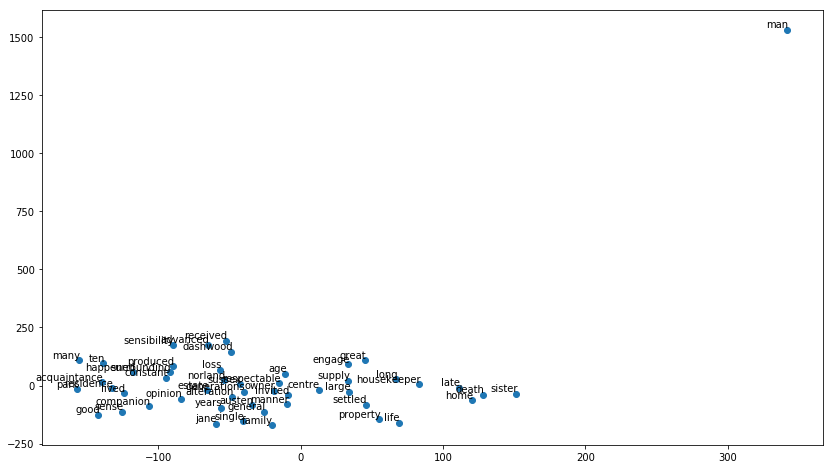

In [15]:
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50
T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right',va='bottom')